# Identifying and annotating astrocyte subtypes in the mouse brain snRNA data

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
from matplotlib import rcParams
import seaborn as sns

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### Outline

1. Loading Visium data and single cell reference
2. Show UMAP of cells and locations
3. cell2location analysis in one step
4. Automatic discrete region identification by clustering cell densities
5. Visualize cell type density gradients using diffusion maps

## 1. Loading Visium data and single cell reference

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [3]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/viseum_cortex_trial/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/mouse_viseum_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/'

sample_data = pd.read_csv(sp_data_folder + 'Visum_mouse.csv')

In [4]:
sample_data

,sample_name,sample_name2,image_name,slide,position
0,ST8059048,Visium-28C,mouse_brain_he_Library_028_C05717_020_C1_14460...,C05717-020,C1
1,ST8059049,Visium-28D,mouse_brain_he_Library_028_C05717_020_D1_14460...,C05717-020,D1
2,ST8059050,Visium-28E,mouse_brain_he_Library_028_C05717_020_E1_14460...,C05717-020,E1
3,ST8059051,Visium-29B,mouse_brain_he_Library_029_C05717_021_B1_14460...,C05717-021,B1
4,ST8059052,Visium-29C,mouse_brain_he_Library_029_C05717_021_C1_14460...,C05717-021,C1


In [5]:
sc.logging.print_versions()

-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
anndata             0.7.4
arviz               0.8.3
backcall            0.2.0
cairo               1.19.1
cell2location       NA
cffi                1.14.0
cftime              1.1.3
cutils_ext          NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
descartes           NA
fastprogress        0.2.3
get_version         2.1
h5py                2.10.0
igraph              0.8.2
importlib_metadata  1.7.0
ipykernel           5.3.0
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.17.1
joblib              0.16.0
kiwisolver          1.2.0
lazylinker_ext      NA
legacy_api_wrap     0.0.0
leidenalg           0.8.0
llvmlite            0.32.1
louvain             0.6.1
mako                1.1.0
markupsafe          1.1.1
matplotlib          3.2.2
mizani              0.7.1
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.0.1
netCDF4    

### Read snRNA-seq reference

```python
## snRNA reference (raw counts)
def read_10x_output(file_path, smp_list, metadata=None, type = 'h5', umi_filter=5):
    
    #Writing output from separate samples, processed using CellRanger, into a dictionary of Scanpy objects:
    ad = {}

    #Generate AnnData for each sample
    for sample_name in smp_list:
        path = file_path + sample_name
        for i in os.listdir(path):
            if type in i:
                file = i
        ad[sample_name] = sc.read_10x_h5(file_path + sample_name +'/'+file)
        ad[sample_name].var.rename(columns = {'gene_ids':'ENSEMBL'}, inplace = True)
        ad[sample_name].var['SYMBOL'] = ad[sample_name].var.index
        ad[sample_name].var.index = ad[sample_name].var['ENSEMBL']
        ad[sample_name].var.drop(columns=['ENSEMBL'], inplace=True)
        #ad[sample_name].var_names_make_unique() 
        
        
        sc.pp.calculate_qc_metrics(ad[sample_name], inplace=True)
        ad[sample_name] = ad[sample_name][ad[sample_name].obs['total_counts'] > umi_filter, :]
        ad[sample_name].var['mt'] = [gene.startswith('mt-') 
                                     for gene in ad[sample_name].var['SYMBOL']]
        ad[sample_name].obs['mt_frac'] = (ad[sample_name][:, 
               ad[sample_name].var['mt'].tolist()].X.sum(1).A.squeeze() 
                                          / ad[sample_name].obs['total_counts'])
        
        ad[sample_name].obs['sample'] = sample_name
        ad[sample_name].obs['barcode'] = ad[sample_name].obs_names
        ad[sample_name].obs_names = ad[sample_name].obs['sample']+"_"+ad[sample_name].obs['barcode']

    #Merge AnnData objects from all the samples together    
    from scipy.sparse import vstack
    stack = vstack([ad[x].X for x in smp_list]) # stack data
    adata = sc.AnnData(stack, var = ad[smp_list[0]].var)
    adata.obs = pd.concat([ad[x].obs for x in smp_list], axis = 0)

    if metadata is not None:
        #Add cleaned metadata to the Anndata.obs table
        obs_merged = pd.merge(left = adata.obs, right = metadata, 
                              how = "left", left_on="sample", right_on="SampleID")
        obs_merged.index = obs_merged['sample']+"_"+obs_merged['barcode']
        print(obs_merged.index.equals(adata.obs.index))
        adata.obs = obs_merged

    return adata, ad

adata_snrna_raw, ad_list = read_10x_output(
    sc_data_folder + 'rawdata/', 
    smp_list=os.listdir(sc_data_folder + 'rawdata/filtered_feature_bc_matrix'),
    metadata=None, type = 'h5')
```

```python
# PLOT QC FOR EACH SAMPLE 
rcParams["axes.facecolor"] = "white"
rcParams["figure.figsize"] = [10, 15]
rcParams["font.size"] = 12

fig, axs = plt.subplots(len(ad_list), 4, figsize=(15, 4*len(ad_list)-4))
for i in range(len(ad_list)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(np.log10(list(ad_list.values())[i].obs['total_counts']), 
                 kde=False, ax = axs[i, 0], hist_kws={'log': True})
    axs[i, 0].set_xlim(0, np.log10(adata_snrna_raw.obs['total_counts'].max()))
    axs[i, 0].set_xlabel('total_counts | ' + list(ad_list.keys())[i])
    
    sns.distplot(np.log10(list(ad_list.values())[i].obs['total_counts']\
                 [list(ad_list.values())[i].obs['total_counts']<20000]),
                 kde=False, bins=40, ax = axs[i, 1], hist_kws={'log': True})
    axs[i, 1].set_xlim(0, np.log10(20000))
    axs[i, 1].set_xlabel('total_counts | ' + list(ad_list.keys())[i])
    
    sns.distplot(np.log10(list(ad_list.values())[i].obs['n_genes_by_counts']),
                 kde=False, bins=60, ax = axs[i, 2], hist_kws={'log': True})
    axs[i, 2].set_xlim(0, np.log10(adata_snrna_raw.obs['n_genes_by_counts'].max()))
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(ad_list.keys())[i])
    
    sns.distplot(np.log10(list(ad_list.values())[i].obs['n_genes_by_counts']\
                 [list(ad_list.values())[i].obs['n_genes_by_counts']<6000]),
                 kde=False, bins=60, ax = axs[i, 3], hist_kws={'log': True})
    axs[i, 3].set_xlim(0, np.log10(6000))
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(ad_list.keys())[i])
    
plt.tight_layout()
```

```python
# export aggregated and pre-processed data
adata_snrna_raw.write(sc_data_folder + 'rawdata/all_cells_with_empty_20200625.h5ad')

# select and export cells with annotations
labels = pd.read_csv(results_folder + 'snRNA_annotation_20200229.csv', index_col=0)
cell_ind = adata_snrna_raw.obs_names.isin(labels.index)
adata_snrna_raw = adata_snrna_raw[cell_ind,:]
adata_snrna_raw.write(sc_data_folder + 'rawdata/all_cells_20200625.h5ad')
```

In [11]:
## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "rawdata/all_cells_20200625.h5ad")

## Cell type annotations
labels = pd.read_csv(results_folder + 'snRNA_annotation_astro_subtypes_refined58_20200828.csv', index_col=0)

sub_labels = pd.read_csv(results_folder + "snRNA_annotation_subclusters_20200207.csv", index_col=0)

# remove 'NonNeu_' from astro names
from re import sub
sub_labels['annotation_subclusters'] = [sub('NonNeu_', '', i) for i in sub_labels['annotation_subclusters']]

Add cell type labels as columns in `adata.obs`

In [14]:
labels = labels.reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs[labels.columns] = labels
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['annotation_1'].isna(), :]

# remove likely doublet clusters
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['annotation_1'].isin(['Ext_Hpc_14', 'Ext_Hpc_15']),:]

Select genes using expression in non-zero cells

Trying to set attribute `.obs` of view, copying.


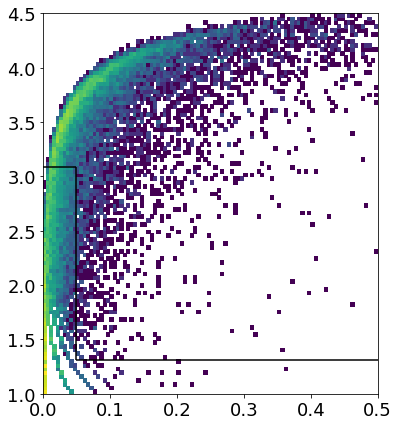

In [15]:
# Select cells
#min_genes = 1000  
rcParams["axes.facecolor"] = "white"

sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=matplotlib.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0005)
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2);
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1);
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff);

In [16]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(40532, 12819)

In [17]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)
              & np.array(~adata_snrna_raw.var['SYMBOL'].isna())]

Add counts matrix as `adata.raw` 

In [18]:
adata_vis = adata.copy()
adata_snrna_raw.raw = adata_snrna_raw
adata_vis.raw = adata_vis

In [19]:
adata_snrna_raw.obs['annotation_1'] = adata_snrna_raw.obs['annotation_1'].astype('category')
adata_snrna_raw.obs['annotation_1_int'] = adata_snrna_raw.obs['annotation_1'].cat.codes.astype('category')
adata_snrna_raw.obs['annotation_1_print'] = [str(adata_snrna_raw.obs['annotation_1_int'][i]) \
                                             + '_' + str(adata_snrna_raw.obs['annotation_1'][i])
                                             for i in range(adata_snrna_raw.shape[0])]

In [20]:
adata_snrna_raw

AnnData object with n_obs × n_vars = 40532 × 12819
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation_1', 'n_genes', 'annotation_1_int', 'annotation_1_print'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean'

## Subcluster astrocytes

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'annotation_1' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'seurat_clusters' as categorical


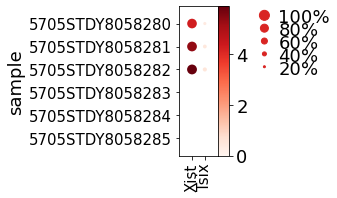

(3031, 7591)


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


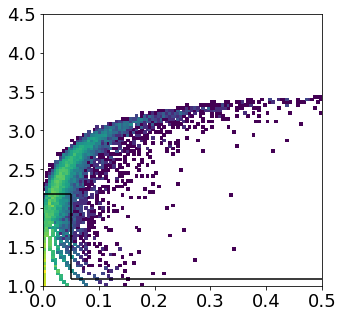

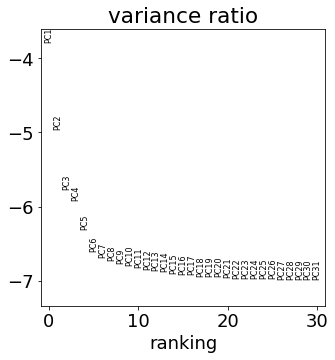

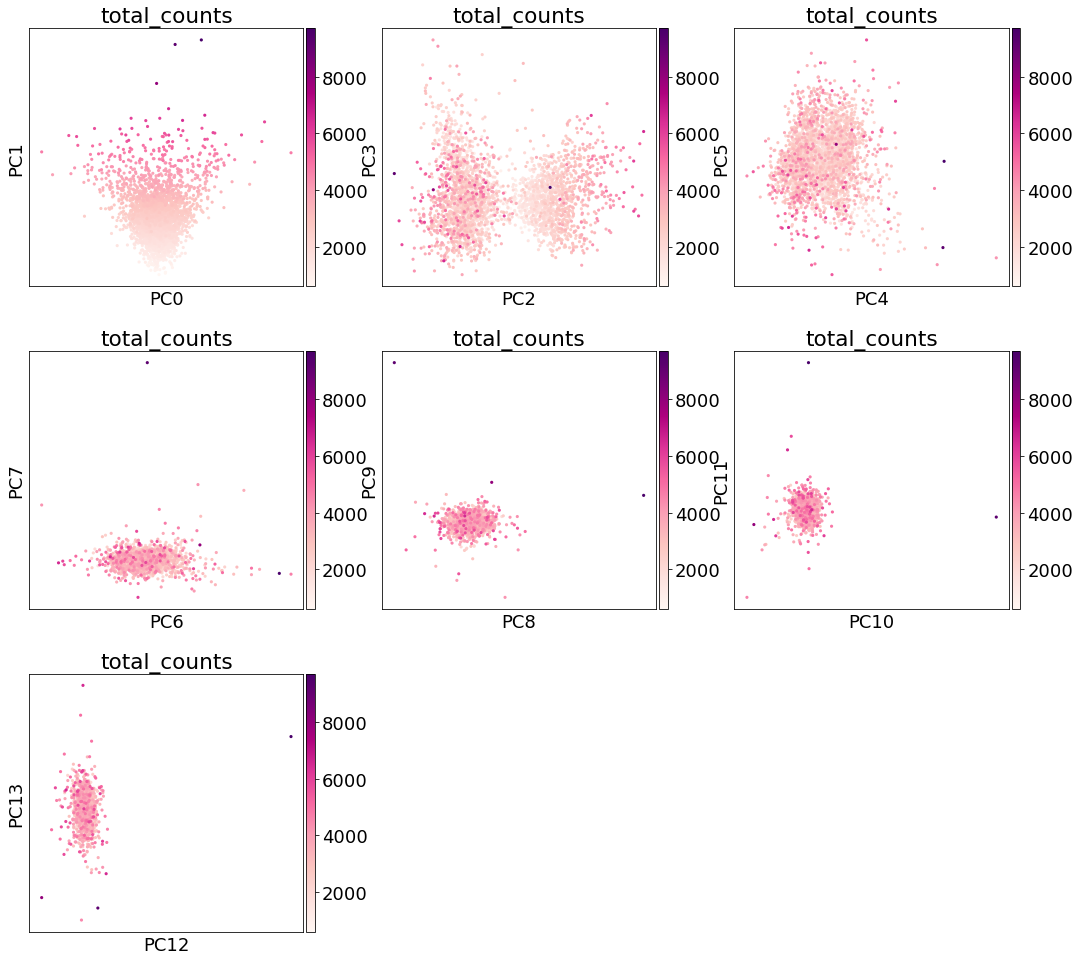

5705STDY8058285    792
5705STDY8058281    584
5705STDY8058280    539
5705STDY8058282    447
5705STDY8058283    394
5705STDY8058284    275
Name: sample, dtype: int64


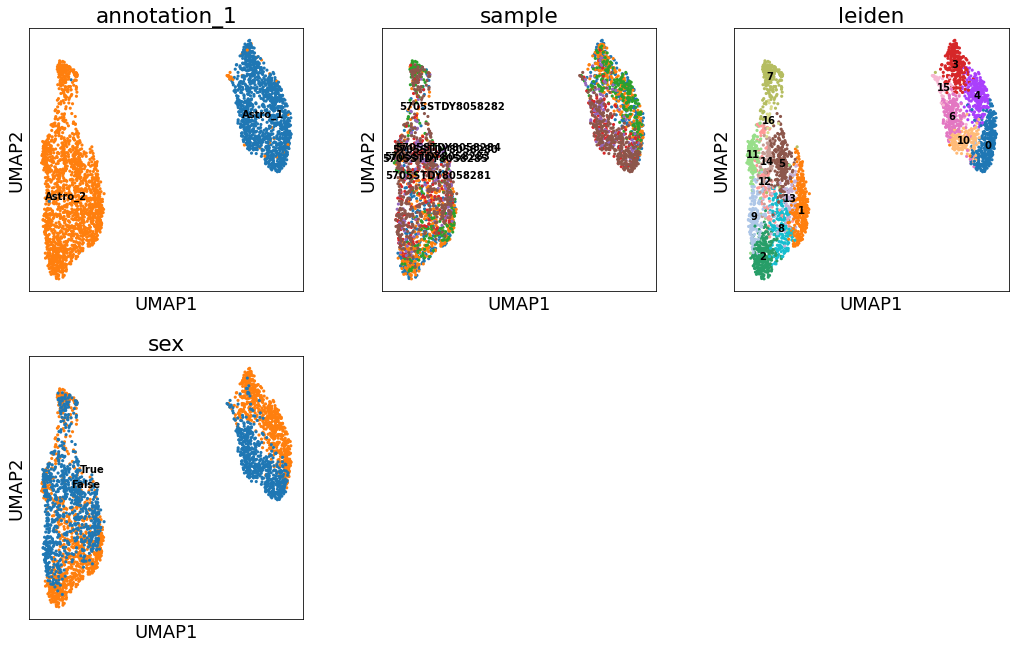

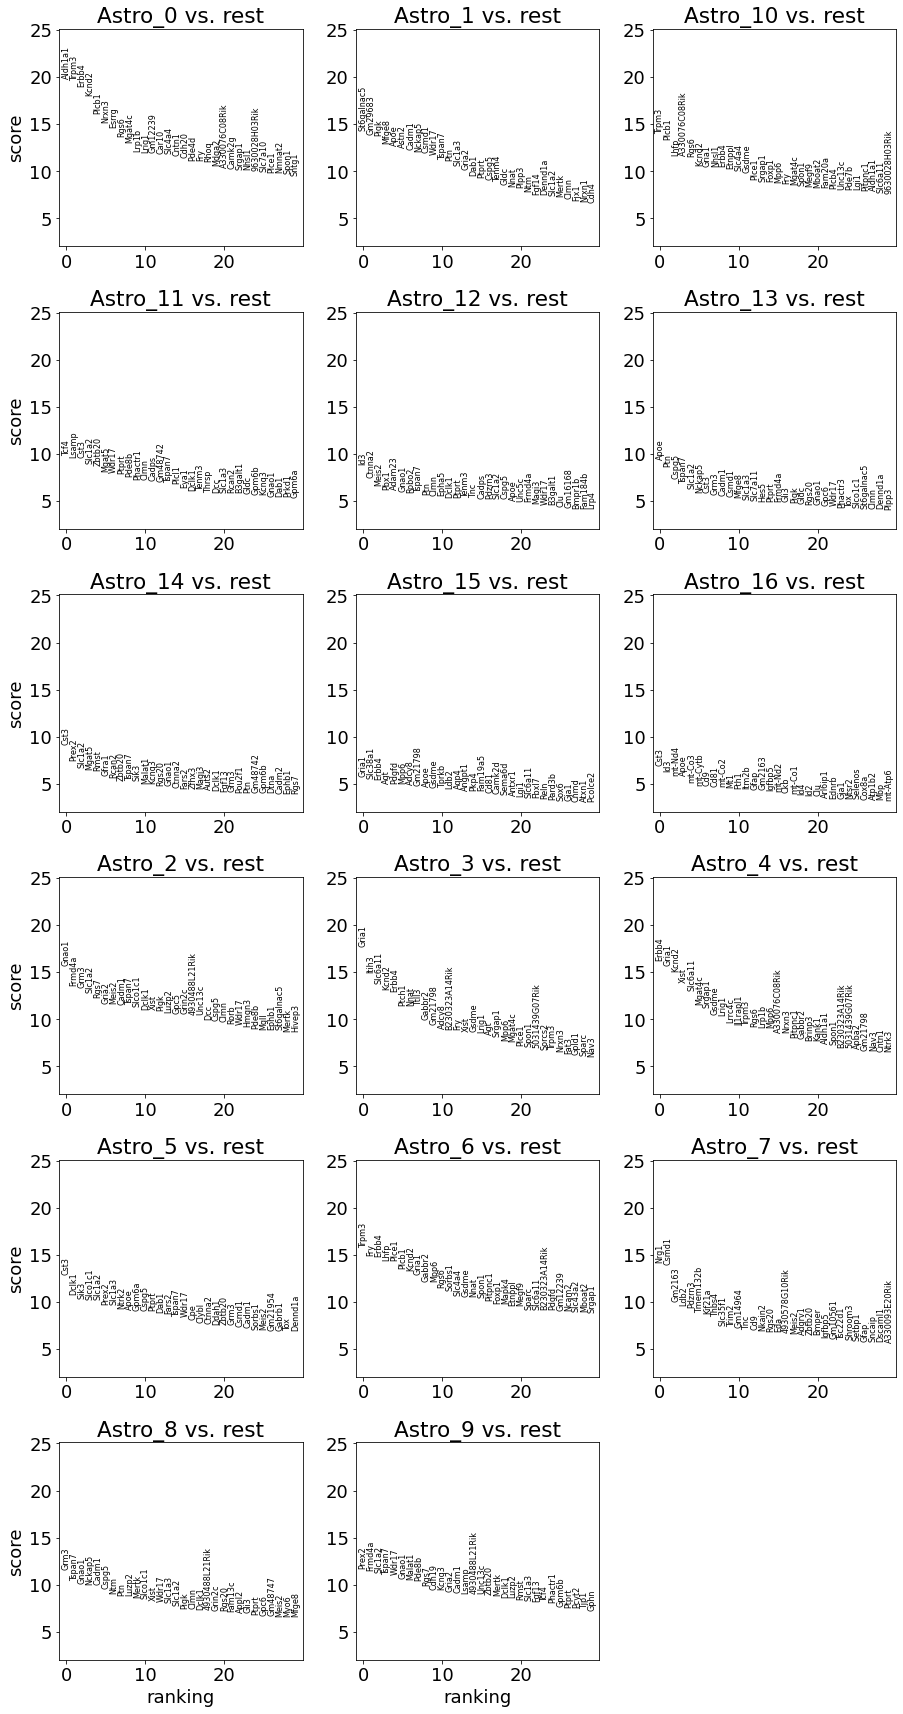

         Falling back to preprocessing with `sc.pp.pca` and default params.


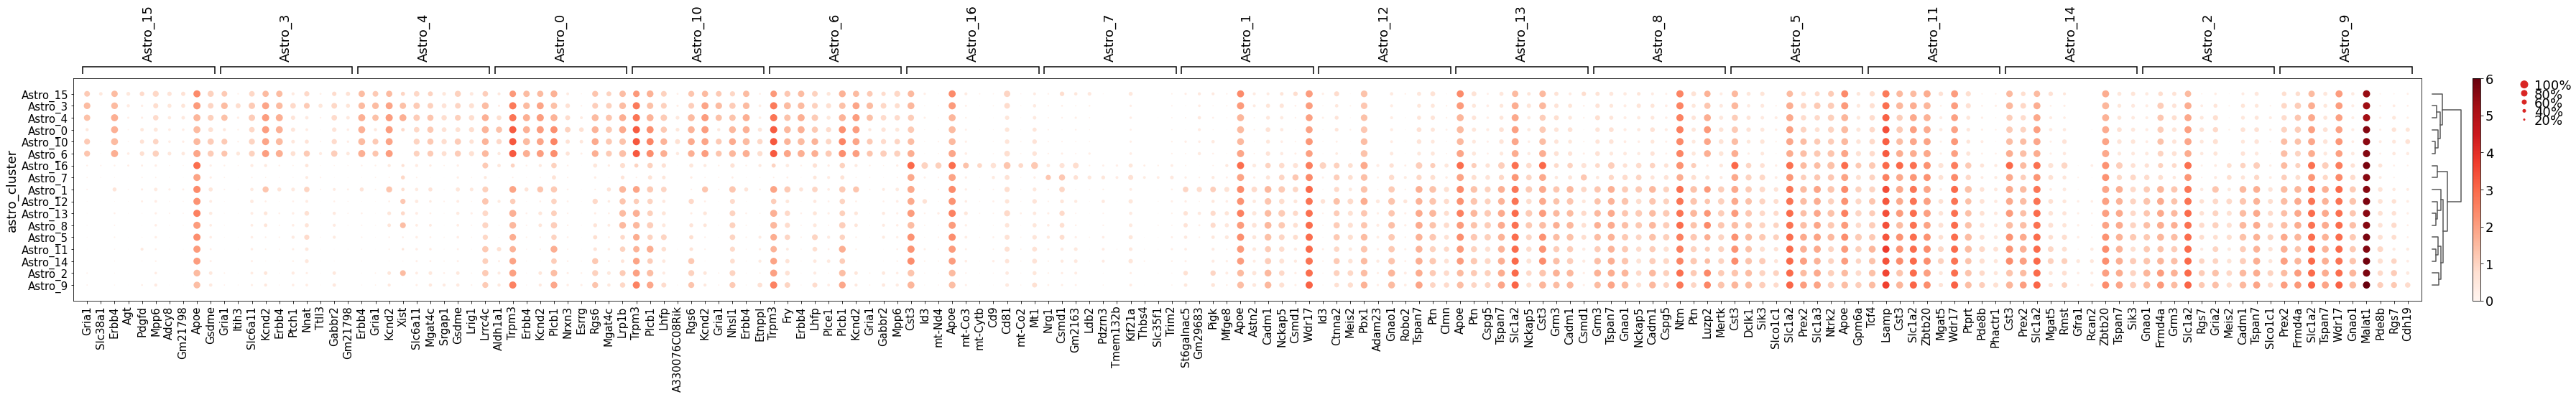

Astro_0     333
Astro_1     284
Astro_2     274
Astro_3     252
Astro_4     242
Astro_5     214
Astro_6     204
Astro_7     200
Astro_8     193
Astro_9     169
Astro_10    163
Astro_11    154
Astro_12    107
Astro_13     86
Astro_14     81
Astro_15     54
Astro_16     21
Name: astro_cluster, dtype: int64


annotation_subclusters,Astro_0,Astro_1,Astro_2,Astro_3,Astro_4
astro_cluster,,,,,
Astro_0,0,69,2,97,0
Astro_1,98,0,37,0,4
Astro_10,0,3,0,0,1
Astro_11,37,0,8,0,5
Astro_12,52,0,20,0,8
Astro_13,35,0,12,0,2
Astro_14,9,0,1,0,0
Astro_15,1,18,0,11,2
Astro_16,5,1,1,0,2


In [37]:
## snRNA reference (raw counts)
astro = anndata.read_h5ad(sc_data_folder + "rawdata/all_cells_20200625.h5ad")

astro.obs['sex'] = [s in ['5705STDY8058281', '5705STDY8058280', '5705STDY8058282'] 
                    for s in astro.obs['sample']]
astro.obs['sex'] = astro.obs['sex'].astype('category')

## Cell type annotations
labels = pd.read_csv(results_folder + 'snRNA_annotation_20200229.csv', index_col=0)

astro = astro[labels.index,]
astro.obs[labels.columns] = labels

# select astrocytes
astro_ind = labels.index[labels['annotation_1'].isin(['Astro_1', 'Astro_2'])]
astro = astro[astro_ind,:]

sc.pl.dotplot(astro, ['Xist', 'Tsix'], groupby='sample', gene_symbols='SYMBOL');

#########################
# keep raw data
astro_raw = astro.copy()

# Select cells
rcParams["axes.facecolor"] = "white"

sc.pp.filter_cells(astro, min_genes=1)
sc.pp.filter_genes(astro, min_cells=1)

# calculate the mean of each gene across non-zero cells
astro.var['n_cells'] = (astro.X.toarray() > 0).sum(0)
astro.var['nonz_mean'] = astro.X.toarray().sum(0) / astro.var['n_cells']

plt.hist2d(np.log10(astro.var['nonz_mean']),
           np.log10(astro.var['n_cells']), bins=100,
           norm=matplotlib.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(astro.shape[0] * 0.004)
cell_count_cutoff2 = np.log10(astro.shape[0] * 0.05)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2);
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1);
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff);

print(astro[:,(np.array(np.log10(astro.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(astro.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(astro.var['n_cells']) > cell_count_cutoff)].shape)

# select genes based on mean expression in non-zero cells
astro = astro[:,(np.array(np.log10(astro.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(astro.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(astro.var['n_cells']) > cell_count_cutoff)
              & np.array(~astro.var['SYMBOL'].isna())]

astro.raw = astro
#########################

sc.pp.log1p(astro)

# Find highly variable genes within each sample
astro.var['highly_variable'] = False
for s in astro.obs['sample'].unique():
    
    astro_1 = astro[astro.obs['sample'].isin([s]), :]
    sc.pp.highly_variable_genes(astro_1, min_mean=0.0012, max_mean=10, min_disp=0.3, n_top_genes=1000)
    
    hvg_list = list(astro_1.var_names[astro_1.var['highly_variable']])
    astro.var.loc[hvg_list, 'highly_variable'] = True

sc.pp.scale(astro, max_value=10)
sc.tl.pca(astro, svd_solver='arpack', n_comps=70, use_highly_variable=False)
sc.pl.pca_variance_ratio(astro, log=True)
sc.pl.pca(astro, color=['total_counts'],
          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
          color_map = 'RdPu', ncols = 3, legend_loc='on data',
          legend_fontsize=10, gene_symbols='SYMBOL')
astro.obsm['X_pca'] = astro.obsm['X_pca'][:, 1:]
astro.varm['PCs'] = astro.varm['PCs'][:, 1:]
#########################

import bbknn
bbknn.bbknn(astro, neighbors_within_batch = 3, batch_key = 'sample', n_pcs = 30)
sc.tl.umap(astro, min_dist = 0.2, spread = 0.8)

print(astro.obs['sample'].value_counts())

#########################

sc.tl.leiden(astro, resolution=2.4)

#########################
astro_raw.obs['astro_cluster'] = astro.obs['leiden']
astro_raw.obs['astro_cluster'] = [f'Astro_{i}' for i in astro_raw.obs['astro_cluster']]
astro_raw.obs['astro_cluster'] = astro_raw.obs['astro_cluster'].astype('category')
astro_raw_sel = astro_raw.copy()
sc.tl.rank_genes_groups(astro_raw_sel, 'astro_cluster', method='wilcoxon')
sc.pl.rank_genes_groups(astro_raw_sel, gene_symbols='SYMBOL', n_genes=30, ncols=3)

astro_raw_sel.var_names = astro_raw_sel.var['SYMBOL']
astro_raw_sel.raw = astro_raw_sel

sc.pp.log1p(astro_raw_sel)
sc.tl.rank_genes_groups(astro_raw_sel, 'astro_cluster', method='wilcoxon',
                        use_raw=False)

sc.pl.rank_genes_groups_dotplot(astro_raw_sel, n_genes=10, use_raw=False)

sub_labels['astro_cluster'] = astro_raw.obs['astro_cluster'].reindex(index=sub_labels.index)

#########################
astro_raw.obsm['X_umap'] = astro.obsm['X_umap']
astro_raw.obsm['X_pca'] = astro.obsm['X_pca']
astro_markers = ['Unc13c', 'Agt', 
                 'Chrdl1', 'Eogt', 'Igfbp2',
                 'Il33', 'Pamr1', 'Lrig1', 'Hyou1',
                 'Efhd2','Mfge8', 'mt-Co3']

rcParams['figure.figsize'] = 5, 5
rcParams["axes.facecolor"] = "white"
sc.pl.umap(astro_raw, color=['annotation_1', 'sample', 'astro_cluster', 'sex'] + astro_markers,
           color_map = 'RdPu', ncols = 3, legend_loc='on data',
           legend_fontsize=10, gene_symbols='SYMBOL')
sc.pl.dotplot(astro_raw, astro_markers, groupby='astro_cluster', gene_symbols='SYMBOL');


#########################

print(astro_raw.obs['astro_cluster'].value_counts())
pd.crosstab(sub_labels['astro_cluster'], sub_labels['annotation_subclusters'])

In [38]:
adata_snrna_raw.obs['astro_cluster'] = astro_raw.obs['astro_cluster'].reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs['annotation_1'] = adata_snrna_raw.obs['annotation_1'].astype(str)
adata_snrna_raw.obs['annotation_1'][~adata_snrna_raw.obs['astro_cluster'].isna().values] = \
    adata_snrna_raw.obs['astro_cluster'][~adata_snrna_raw.obs['astro_cluster'].isna().values]

adata_snrna_raw.obs['annotation_1'].to_csv(f'{results_folder}snRNA_annotation_cortical_astro_subtypes{len(astro_raw.obs["astro_cluster"].unique())}_no_cov_bbknn_20200806.csv')

f'{results_folder}snRNA_annotation_cortical_astro_subtypes{len(astro_raw.obs["astro_cluster"].unique())}_no_cov_bbknn_20200806.csv'

'/nfs/team205/vk7/sanger_projects/cell2location_dev/notebooks/results/mouse_viseum_snrna/snRNA_annotation_cortical_astro_subtypes17_no_cov_bbknn_20200806.csv'

# 3. cell2location analysis in two steps: infer and locate regulatory programmes

In [28]:
reg_mod_name = 'RegressionNBV2Torch_71covariates_40554cells_12817genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']

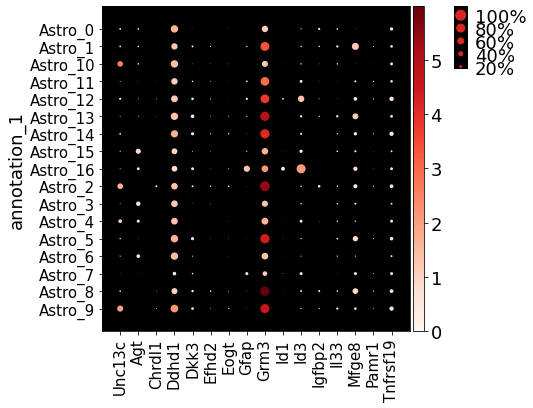

In [29]:
astro_ind = adata_snrna_raw.obs['annotation_1'].isin([f'Astro_{i}' for i in range(21)])
astro = adata_snrna_raw[astro_ind,:]
rcParams["axes.facecolor"] = "black"

sc.pl.dotplot(astro, [
    'Unc13c', 'Agt',
    'Chrdl1',
'Ddhd1',
'Dkk3',
'Efhd2',
'Eogt',
'Gfap',
'Grm3',
'Id1',
'Id3',
'Igfbp2',
'Il33',
'Mfge8',
'Pamr1',
'Tnfrsf19'], groupby='annotation_1', gene_symbols='SYMBOL');

In [30]:
# New annotation
adata_snrna_raw.obs['annotation_1_old'] = adata_snrna_raw.obs['annotation_1'].copy()
adata_snrna_raw.obs['annotation_1'] = adata_snrna_raw.obs['annotation_1'].astype(str)

# Thalamic
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_0'])] = \
'Astro_THAL_lat'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_4', 'Astro_10'])] = \
'Astro_THAL_med'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_15'])] = \
'Astro_THAL_hab'

# Hypothalamic
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_3'])] = \
'Astro_HYPO'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_6'])] = \
'Astro_HYPO_THAL'

# Cortex
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_1'])] = \
'Astro_AMY_1'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_5'])] = \
'Astro_AMY_2'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_2', 'Astro_9'])] = \
'Astro_CTX'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_11', 'Astro_12'])] = \
'Astro_HPC'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_14'])] = \
'Astro_STR'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_8', 'Astro_13'])] = \
'Astro_AMY_CTX'

# WM
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_7'])] = \
'Astro_WM_1'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_16'])] = \
'Astro_WM_2'

In [31]:
adata_snrna_raw.obs['annotation_1'].to_csv(f'{results_folder}snRNA_annotation_astro_subtypes_refined{len(adata_snrna_raw.obs["annotation_1"].unique())}_20200807.csv')
f'{results_folder}snRNA_annotation_astro_subtypes_refined{len(adata_snrna_raw.obs["annotation_1"].unique())}_20200807.csv'

'/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/snRNA_annotation_astro_subtypes_refined58_20200823.csv'

In [113]:
reg_mod_name = 'RegressionNBV2Torch_68covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

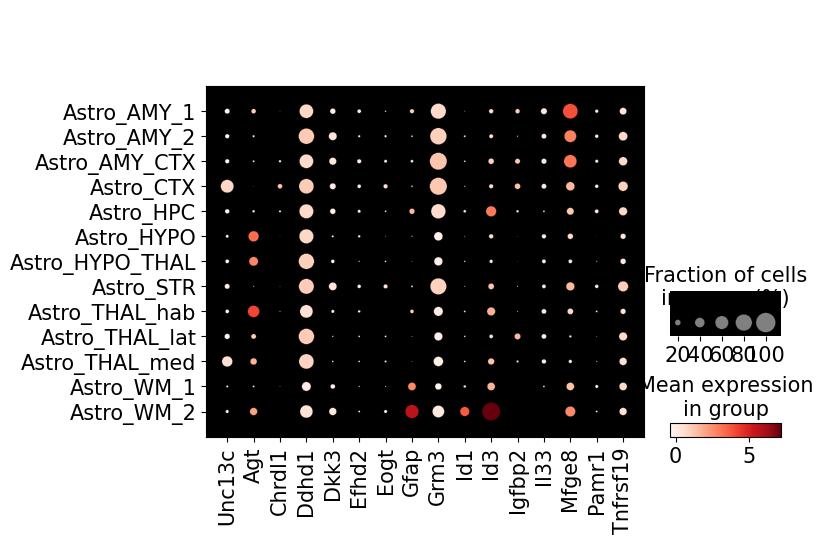

In [114]:
astro_ind = ['Astro_' in i for i in adata_snrna_raw.obs['annotation_1']]
astro = adata_snrna_raw[astro_ind,:]
rcParams["axes.facecolor"] = "black"

sc.pl.dotplot(astro, [
    'Unc13c', 'Agt',
    'Chrdl1',
'Ddhd1',
'Dkk3',
'Efhd2',
'Eogt',
'Gfap',
'Grm3',
'Id1',
'Id3',
'Igfbp2',
'Il33',
'Mfge8',
'Pamr1',
'Tnfrsf19'], groupby='annotation_1', use_raw=False, gene_symbols='SYMBOL');
rcParams["axes.facecolor"] = "white"

In [110]:
# New annotation
adata_snrna_raw.obs['annotation_1_old'] = adata_snrna_raw.obs['annotation_1'].copy()
adata_snrna_raw.obs['annotation_1'] = adata_snrna_raw.obs['annotation_1'].astype(str)

adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_HYPO', 'Astro_HYPO_THAL'])] = \
'Astro_HYPO'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_AMY_1', 'Astro_AMY_2'])] = \
'Astro_AMY'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Astro_WM_1', 'Astro_WM_2'])] = \
'Astro_WM'

In [116]:
adata_snrna_raw.obs['annotation_1'].to_csv(f'{results_folder}snRNA_annotation_astro_subtypes_refined{len(adata_snrna_raw.obs["annotation_1"].unique())}_20200831.csv')
f'{results_folder}snRNA_annotation_astro_subtypes_refined{len(adata_snrna_raw.obs["annotation_1"].unique())}_20200831.csv'

'/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/snRNA_annotation_astro_subtypes_refined58_20200831.csv'

Trying to set attribute `.obs` of view, copying.
... storing 'annotation_1' as categorical


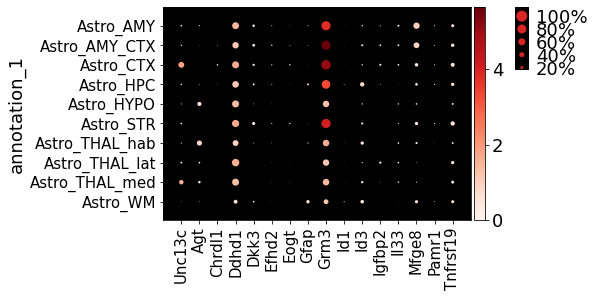

In [32]:
astro_ind = ['Astro_' in i for i in adata_snrna_raw.obs['annotation_1']]
astro = adata_snrna_raw[astro_ind,:]
rcParams["axes.facecolor"] = "black"

sc.pl.dotplot(astro, [
    'Unc13c', 'Agt',
    'Chrdl1',
'Ddhd1',
'Dkk3',
'Efhd2',
'Eogt',
'Gfap',
'Grm3',
'Id1',
'Id3',
'Igfbp2',
'Il33',
'Mfge8',
'Pamr1',
'Tnfrsf19'], groupby='annotation_1', gene_symbols='SYMBOL');

astro.obs['annotation_1'].value_counts()
rcParams["axes.facecolor"] = "white"

In [ ]:
# final subtype annotation is the following
{
 'Astro_THAL_lat': ['Astro_0'],
 'Astro_THAL_med': ['Astro_4', 'Astro_10'],
 'Astro_THAL_hab': ['Astro_15'],
 'Astro_HYPO': ['Astro_3', 'Astro_6'],
 'Astro_AMY': ['Astro_1', 'Astro_5'],
 'Astro_CTX': ['Astro_2', 'Astro_9'],
 'Astro_HPC': ['Astro_11', 'Astro_12'],
 'Astro_STR': ['Astro_14'],
 'Astro_AMY_CTX': ['Astro_8', 'Astro_13'],
 'Astro_WM': ['Astro_7', 'Astro_16']
}

Modules and their versions used for this analysis

In [ ]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass